# Регуляризация. Гребневая регрессия. Лассо регрессия


Обзор набора данных
Этот набор данных содержит 2Lk+ и 20 признаков с комбинацией категориальных, числовых и текстовых данных.  
Он включает пропущенные значения, неверные типы данных и перекошенные распределения для имитации сложностей, с которыми сталкиваются реальные наборы данных.  
Целевая переменная для прогнозирования — «Premium Amount».

Признаки (столбцы):  
Возраст - Age : Возраст застрахованного лица (числовой)  
Пол - Gender : Пол застрахованного лица (Категория: Мужской, Женский)  
Годовой доход - Annual Income : Годовой доход застрахованного лица (числовой, асимметричный)  
Семейное положение - Marital Status : Семейное положение застрахованного лица (категория: холост, женат, разведен)  
Количество иждивенцев - Number of Dependents : Количество иждивенцев (числовое, с пропущенными значениями)  
Уровень образования Education Level : наивысший достигнутый уровень образования (категория: средняя школа, бакалавр, магистр, доктор философии)  
Род занятий - Occupation : Род занятий застрахованного лица (категория: работающий по найму, самозанятый, безработный)  
Оценка состояния здоровья - Health Score : оценка, отражающая состояние здоровья (числовая, асимметричная)  
Местоположение - Location : Тип местоположения (Категория: Город, Пригород, Сельская местность)  
Тип полиса - Policy Type : Тип страхового полиса (Категорийный: Базовый, Комплексный, Премиум)  
Предыдущие заявления - Previous Claims : Количество предыдущих заявлений (числовое, с выбросами)  
Возраст транспортного средства - Vehicle Age : Возраст застрахованного транспортного средства (числовой)  
Кредитный рейтинг - Credit Score : кредитный рейтинг застрахованного лица (числовой, с отсутствующими значениями)  
Срок действия страхового полиса - Insurance Duration : Срок действия страхового полиса (числовой, в годах)  
Дата начала действия полиса - Policy Start Date : Дата начала действия страхового полиса (Текст, неправильно отформатирован)  
Отзывы клиентов - Customer Feedback : краткие отзывы клиентов (текст)  
Статус курения  - Smoking Status  : Статус курения застрахованного лица (Категория: Да, Нет)  
Частота упражнений - Exercise Frequency : Частота упражнений (Категория: Ежедневно, Еженедельно, Ежемесячно, Редко)  
Тип недвижимости  - Property Type : Тип собственности (Категория: Дом, Квартира, Кондоминиум)  

Целевая переменная:  
Сумма страховой премии Premium Amount : целевая переменная, представляющая сумму страховой премии (числовая, асимметричная)  

## Импорты

In [1]:
from glob import glob
import os 
import pathlib 

import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,  MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_log_error

In [2]:
print("Виртуальное окружение:")
!which python 
# Текущее положение
path_1 = os.getcwd()
print("\nТекущее положение: \n", path_1)
print("\nРасположение датасета:")
!ls dataset

Виртуальное окружение:
/home/maksim/develops/python/MAKSIM/.venv/bin/python

Текущее положение: 
 /home/maksim/develops/python/MAKSIM/ML/regularisation

Расположение датасета:
sample_submission.csv  test.csv  train.csv


## Функции

In [ ]:
def cleaning_resource(var_name=None):
    ''' 
        Очистка памяти для указанной переменной
    '''
    import gc
    import sys
    from pympler import asizeof
    if var_name in globals():  # Проверяем, существует ли глобальная переменная
        size1 = asizeof.asizeof(globals()[var_name])  # Измеряем реальный размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del globals()[var_name]
        print(f"✅ Объект {var_name} удалён")
    elif var_name in locals():  # Проверяем локальную переменную
        size1 = asizeof.asizeof(locals()[var_name])  # Измеряем размер
        print(f"Объём переменной: {size1 / (1024**2):.2f} МБ")  # В мегабайтах
        del locals()[var_name]
        print(f"✅ Локальный объект {var_name} удалён")
    else:
        print(f"⚠️ Переменная {var_name} не найдена, но память очищена")

    gc.collect()  # Очистка памяти



def plot_histogram_box(data, col='Premium Amount'):
    ''' 
        Функция построения графиков попарно, гистограмма и Ящик с усами
    '''
    # Создаем два графика в одной строке (1 строка, 2 столбца)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма
    sns.histplot(data[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(f'{col}')
    axes[0].set_ylabel('Частота')

    # Boxplot (ящик с усами)
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Ящик с усами  {col}')
    axes[1].set_xlabel(f'{col}')

    # Показываем оба графика в одном окне
    plt.tight_layout()
    plt.show()
    
    
def plot_histogram_chart(data, col=''):
    ''' 
        Функция построения графиков попарно, гистограмма и круговой
    '''
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  

    # Гистограмма (countplot)
    sns.countplot(x=data[col], ax=axes[0])
    axes[0].set_title(f'Гистограмма {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Частота')
    axes[0].tick_params(axis='x', rotation=45)  

    # Pie chart (круговая диаграмма)
    data[col].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90, cmap='Set3')
    axes[1].set_title(f'Распределение категорий в {col}')
    axes[1].set_ylabel('')  
    # Выводим оба графика
    plt.tight_layout()
    plt.show()
    
    

def plot_analize_data(data1, num_col_del, cat_col_del):
    ''' 
        Строит в цикле попарно графики для числовых и категориальных столбцов
    '''
    data = data1.drop(columns=num_col_del, errors='ignore')  
    numeric_columns = data.select_dtypes(include=[np.number])  # Выбираем числовые столбцы

    for col in numeric_columns.columns:
        plot_histogram_box(data, col)
        
        
    # Выбираем категориальные столбцы (кроме 'Policy Start Date')
    data2 = data1.drop(columns=cat_col_del, errors='ignore')
    categorical_columns = data2.select_dtypes(exclude=[np.number])
    

    # Визуализация категориальных признаков
    for col in categorical_columns.columns:
        plot_histogram_chart(data2, col)
        
  
def analiz_data(data):
    ''' 
        Анализ данных
    '''
    # Выбираем только числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])
    eda_results = pd.DataFrame({
    "Доля пропусков (%)": numeric_columns.isnull().mean() * 100,
    "Максимальное значение": numeric_columns.max(),
    "Минимальное значение": numeric_columns.min(),
    "Среднее значение": numeric_columns.mean(),
    "Медиана": numeric_columns.median(),
    "Дисперсия": numeric_columns.var(),
    "Квантиль 0.1": numeric_columns.quantile(0.1),
    "Квантиль 0.9": numeric_columns.quantile(0.9),
    "Квартиль 1 (25%)": numeric_columns.quantile(0.25),
    "Квартиль 3 (75%)": numeric_columns.quantile(0.75)
    })

    # Выбираем только категориальные столбцы
    categorical_columns = data.select_dtypes(exclude=[np.number])
    # Рассчитываем статистики
    eda_categorical = pd.DataFrame({
        "Доля пропусков (%)": categorical_columns.isnull().mean() * 100,
        "Количество уникальных значений": categorical_columns.nunique(),
        "Наиболее частое значение (мода)": categorical_columns.mode().iloc[0],
        "Частота моды (%)": categorical_columns.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    })

    # Выводим результаты
    print("Числовые признаки: \n")
    print(eda_results.to_string())
    print("\nКатегориальные признаки: \n")
    print(eda_categorical.to_string())
    
    return numeric_columns, categorical_columns




 
def encode_categorical_features(data):
    """
    Кодирует категориальные признаки:
    - Label Encoding для порядковых категорий (Education Level, Exercise Frequency, Policy Type, Location, Occupation)
    - One-Hot Encoding для номинальных категорий (Gender, Marital Status, Smoking Status)
    """

    # 1. Определяем категории
    ordinal_features = ["Education Level", "Exercise Frequency", "Policy Type", "Location", "Occupation"]  # Порядковые категории
    nominal_features = ["Gender", "Marital Status", "Smoking Status"]  # Номинальные категории

    # 2. Кодируем 'Policy Type' вручную
    policy_mapping = {"Basic": 0, "Comprehensive": 1, "Premium": 2}
    if "Policy Type" in data.columns:
        data["Policy Type"] = data["Policy Type"].map(policy_mapping)
        print("Столбец 'Policy Type' закодирован как:", policy_mapping)

    # 3. Кодируем 'Location' вручную
    location_mapping = {"Rural": 0, "Suburban": 1, "Urban": 2}
    if "Location" in data.columns:
        data["Location"] = data["Location"].map(location_mapping)
        print("Столбец 'Location' закодирован как:", location_mapping)

    # 4. Кодируем 'Occupation' вручную
    occupation_mapping = {"Unemployed": 0, "Self-Employed": 1, "Employed": 2}
    if "Occupation" in data.columns:
        data["Occupation"] = data["Occupation"].map(occupation_mapping)
        print("Столбец 'Occupation' закодирован как:", occupation_mapping)

    # 5. Label Encoding для остальных порядковых переменных
    label_encoders = {}
    for col in ordinal_features:
        if col in data.columns and col not in ["Policy Type", "Location", "Occupation"]:  # Эти уже закодированы вручную
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le  # Сохраняем энкодер (для обратного преобразования)

    # 6. One-Hot Encoding для номинальных переменных
    data = pd.get_dummies(data, columns=nominal_features, drop_first=True)  # drop_first=True уменьшает размерность

    return data, label_encoders



def handle_missing_values(data, threshold=35):
    """
    Обрабатывает пропущенные значения:
    - Удаляет столбцы, если пропусков > threshold%
    - 'Number of Dependents' → 0
    - 'Credit Score' → среднее значение
    - 'Property Type' → 'Apartment' (самая частая категория)
    - 'Property Type' → Кодируем: Apartment=0, Condo=1, House=2
    - Остальные числовые столбцы → медиана
    - Категориальные столбцы → мода
    """

    # 1. Считаем процент пропусков в каждом столбце
    missing_percent = data.isnull().mean() * 100

    # 2. Удаляем столбцы, если пропусков > threshold%
    cols_to_drop = missing_percent[missing_percent > threshold].index
    data = data.drop(columns=cols_to_drop)
    print(f"Удалены столбцы с более чем {threshold}% пропусков: {list(cols_to_drop)}\n")

    # 3. Заполняем пропуски в "Number of Dependents" значением 0
    if "Number of Dependents" in data.columns:
        data["Number of Dependents"].fillna(0, inplace=True)
        print("Пропуски в 'Number of Dependents' заменены на 0.\n")

    # 4. Заполняем пропуски в "Credit Score" средним значением
    if "Credit Score" in data.columns:
        mean_credit_score = data["Credit Score"].mean()
        data["Credit Score"].fillna(mean_credit_score, inplace=True)
        print(f"Пропуски в 'Credit Score' заменены на среднее: {mean_credit_score:.2f}\n")

    # 5. Заполняем пропуски в "Property Type")
    if "Property Type" in data.columns:
        data["Property Type"].fillna("House", inplace=True)
        print("Пропуски в 'Property Type' заменены на 'House'.\n")

        # Кодируем 'Property Type' в порядке возрастания
        property_mapping = {"Apartment": 0, "Condo": 1, "House": 2}
        data["Property Type"] = data["Property Type"].map(property_mapping)
        print("Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.\n")

    # 6. Заполняем оставшиеся числовые столбцы медианой
    numeric_columns = data.select_dtypes(include=[np.number]).drop(columns=["Number of Dependents", "Credit Score"], errors="ignore")
    data[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.median())

    # 7. Заполняем остальные категориальные столбцы модой
    categorical_columns = data.select_dtypes(exclude=[np.number])
    for col in categorical_columns.columns:
        data[col].fillna(data[col].mode()[0], inplace=True)

    return data
   
    
def normalize_data(data, method="standard"):
    """
    Нормализует числовые данные.
    method="standard" → StandardScaler (приводит к среднему 0 и std=1)
    method="minmax" → MinMaxScaler (масштабирует от 0 до 1)
    """

    numeric_columns = data.select_dtypes(include=[np.number]).columns  # Только числовые столбцы
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()

    # Применяем масштабирование только к числовым столбцам
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data
    


## 1) Загрузка данных

In [4]:
# Загрузка данных
train_path = "dataset/train.csv"
test_path = "dataset/test.csv"

train_data = pd.read_csv(train_path)
# test_data = pd.read_csv(test_path)

# Просмотр первых строк
print(train_data.head().to_string(index=False))


 id  Age Gender  Annual Income Marital Status  Number of Dependents Education Level    Occupation  Health Score Location   Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration          Policy Start Date Customer Feedback Smoking Status Exercise Frequency Property Type  Premium Amount
  0 19.0 Female        10049.0        Married                   1.0      Bachelor's Self-Employed     22.598761    Urban       Premium              2.0         17.0         372.0                 5.0 2023-12-23 15:21:39.134960              Poor             No             Weekly         House          2869.0
  1 39.0 Female        31678.0       Divorced                   3.0        Master's           NaN     15.569731    Rural Comprehensive              1.0         12.0         694.0                 2.0 2023-06-12 15:21:39.111551           Average            Yes            Monthly         House          1483.0
  2 23.0   Male        25602.0       Divorced                   3.0     High

In [5]:
train_data.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [6]:
train_data.shape

(1200000, 21)

## 2) Анализ данных

In [7]:
print(train_data.describe().to_string())

                 id           Age  Annual Income  Number of Dependents  Health Score  Previous Claims   Vehicle Age  Credit Score  Insurance Duration  Premium Amount
count  1.200000e+06  1.181295e+06   1.155051e+06          1.090328e+06  1.125924e+06    835971.000000  1.199994e+06  1.062118e+06        1.199999e+06    1.200000e+06
mean   5.999995e+05  4.114556e+01   3.274522e+04          2.009934e+00  2.561391e+01         1.002689  9.569889e+00  5.929244e+02        5.018219e+00    1.102545e+03
std    3.464103e+05  1.353995e+01   3.217951e+04          1.417338e+00  1.220346e+01         0.982840  5.776189e+00  1.499819e+02        2.594331e+00    8.649989e+02
min    0.000000e+00  1.800000e+01   1.000000e+00          0.000000e+00  2.012237e+00         0.000000  0.000000e+00  3.000000e+02        1.000000e+00    2.000000e+01
25%    2.999998e+05  3.000000e+01   8.001000e+03          1.000000e+00  1.591896e+01         0.000000  5.000000e+00  4.680000e+02        3.000000e+00    5.140000e+02
50% 

In [8]:
numeric_columns, categorical_columns = analiz_data(train_data)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение        Медиана     Дисперсия   Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
id                              0.000000           1.199999e+06              0.000000     599999.500000  599999.500000  1.200001e+11  119999.900000  1.079999e+06     299999.750000     899999.250000
Age                             1.558750           6.400000e+01             18.000000         41.145563      41.000000  1.833302e+02      22.000000  6.000000e+01         30.000000         53.000000
Annual Income                   3.745750           1.499970e+05              1.000000      32745.217777   23911.000000  1.035521e+09    2627.000000  8.107500e+04       8001.000000      44634.000000
Number of Dependents            9.139333           4.000000e+00              0.000000          2.009934       2.000000  2.008846e+00       0.000000  4.000000e+00          1.000000        

## 3) Подготовка датасета

In [9]:
train_data.isnull().mean() * 100

id                       0.000000
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64

In [10]:
train_data_cleaned = handle_missing_values(train_data)

Удалены столбцы с более чем 35% пропусков: []

Пропуски в 'Number of Dependents' заменены на 0.

Пропуски в 'Credit Score' заменены на среднее: 592.92

Пропуски в 'Property Type' заменены на 'House'.

Столбец 'Property Type' закодирован: Apartment=0, Condo=1, House=2.



/tmp/ipykernel_22810/4107416555.py:275: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Number of Dependents"].fillna(0, inplace=True)
/tmp/ipykernel_22810/4107416555.py:281: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [11]:
numeric_columns, categorical_columns = analiz_data(train_data_cleaned)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение        Медиана     Дисперсия   Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
id                                   0.0           1.199999e+06              0.000000     599999.500000  599999.500000  1.200001e+11  119999.900000  1.079999e+06     299999.750000      899999.25000
Age                                  0.0           6.400000e+01             18.000000         41.143294      41.000000  1.804729e+02      22.000000  6.000000e+01         30.000000          53.00000
Annual Income                        0.0           1.499970e+05              1.000000      32414.310064   23911.000000  9.995464e+08    2699.000000  7.944810e+04       8646.000000       43936.00000
Number of Dependents                 0.0           4.000000e+00              0.000000          1.826239       2.000000  2.160721e+00       0.000000  4.000000e+00          0.000000        

In [12]:
# Не обработаны категориальные столбцы
# Location
# Policy Type
# Occupation

train_data_cleaned["Location"].unique()

array(['Urban', 'Rural', 'Suburban'], dtype=object)

In [13]:
train_data_encoded, label_encoders = encode_categorical_features(train_data_cleaned)


print(train_data_encoded.head().to_string())


Столбец 'Policy Type' закодирован как: {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}
Столбец 'Location' закодирован как: {'Rural': 0, 'Suburban': 1, 'Urban': 2}
Столбец 'Occupation' закодирован как: {'Unemployed': 0, 'Self-Employed': 1, 'Employed': 2}
   id   Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration           Policy Start Date Customer Feedback  Exercise Frequency  Property Type  Premium Amount  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes
0   0  19.0        10049.0                   1.0                0           1     22.598761         2            2              2.0         17.0     372.00000                 5.0  2023-12-23 15:21:39.134960              Poor                   3              2          2869.0        False                    True                  False               False
1   1  39.0        31678.0         

In [14]:
# Не обработан столбец: Policy Start Date
print(train_data_encoded["Policy Start Date"])

0          2023-12-23 15:21:39.134960
1          2023-06-12 15:21:39.111551
2          2023-09-30 15:21:39.221386
3          2024-06-12 15:21:39.226954
4          2021-12-01 15:21:39.252145
                      ...            
1199995    2023-05-03 15:21:39.257696
1199996    2022-09-10 15:21:39.134960
1199997    2021-05-25 15:21:39.106582
1199998    2021-09-19 15:21:39.190215
1199999    2020-08-26 15:21:39.155231
Name: Policy Start Date, Length: 1200000, dtype: object


In [15]:

train_data_encoded["Policy Start Date"] = pd.to_datetime(train_data_encoded["Policy Start Date"])

# Извлекаем только год
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].dt.year  

# Сортируем список уникальных годов
unique_years = sorted(train_data_encoded["Policy Start Date"].unique())

# Создаём словарь для кодирования годов
year_mapping = {year: idx for idx, year in enumerate(unique_years)}

# Применяем замену
train_data_encoded["Policy Start Date"] = train_data_encoded["Policy Start Date"].map(year_mapping)

# Проверяем результат
print(train_data_encoded[["Policy Start Date"]].head())
print(f"Годы закодированы следующим образом: {year_mapping}")

   Policy Start Date
0                  4
1                  4
2                  4
3                  5
4                  2
Годы закодированы следующим образом: {np.int32(2019): 0, np.int32(2020): 1, np.int32(2021): 2, np.int32(2022): 3, np.int32(2023): 4, np.int32(2024): 5}


In [16]:
# Не обработан столбец Customer Feedback
train_data_encoded["Customer Feedback"]

0             Poor
1          Average
2             Good
3             Poor
4             Poor
            ...   
1199995       Poor
1199996       Poor
1199997       Good
1199998       Poor
1199999       Good
Name: Customer Feedback, Length: 1200000, dtype: object

In [17]:
# Не обработан столбец: Customer Feedback
# Определяем правильный порядок для категорий
feedback_mapping = {
    "Average": 1,
    "Good": 2,
    "Poor": 0
}

# Применяем mapping
train_data_encoded["Customer Feedback"] = train_data_encoded["Customer Feedback"].map(feedback_mapping)

# Проверяем результат
print(train_data_encoded["Customer Feedback"].head())

0    0
1    1
2    2
3    0
4    0
Name: Customer Feedback, dtype: int64


In [18]:
train_data_encoded

,id,Age,Annual Income,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,...,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Property Type,Premium Amount,Gender_Male,Marital Status_Married,Marital Status_Single,Smoking Status_Yes
0,0,19.0,10049.0,1.0,0,1,22.598761,2,2,2.0,...,5.0,4,0,3,2,2869.0,False,True,False,False
1,1,39.0,31678.0,3.0,2,2,15.569731,0,1,1.0,...,2.0,4,1,1,2,1483.0,False,False,False,True
2,2,23.0,25602.0,3.0,1,1,47.177549,1,2,1.0,...,3.0,4,2,3,2,567.0,True,False,False,True
3,3,21.0,141855.0,2.0,0,2,10.938144,0,0,1.0,...,1.0,5,0,0,0,765.0,True,True,False,True
4,4,21.0,39651.0,1.0,0,1,20.376094,0,2,0.0,...,4.0,2,0,3,2,2022.0,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,36.0,27316.0,0.0,2,0,13.772907,2,2,1.0,...,3.0,4,0,0,0,1303.0,False,True,False,False
1199996,1199996,54.0,35786.0,0.0,2,1,11.483482,0,1,1.0,...,4.0,3,0,3,0,821.0,True,False,False,False
1199997,1199997,19.0,51884.0,0.0,2,2,14.724469,1,0,0.0,...,6.0,2,2,1,1,371.0,True,False,False,False
1199998,1199998,55.0,23911.0,1.0,3,2,18.547381,1,2,1.0,...,4.0,2,0,0,0,596.0,True,False,True,False


In [19]:
numeric_columns, categorical_columns = analiz_data(train_data_encoded)

Числовые признаки: 

                      Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение        Медиана     Дисперсия   Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
id                                   0.0           1.199999e+06              0.000000     599999.500000  599999.500000  1.200001e+11  119999.900000  1.079999e+06     299999.750000      899999.25000
Age                                  0.0           6.400000e+01             18.000000         41.143294      41.000000  1.804729e+02      22.000000  6.000000e+01         30.000000          53.00000
Annual Income                        0.0           1.499970e+05              1.000000      32414.310064   23911.000000  9.995464e+08    2699.000000  7.944810e+04       8646.000000       43936.00000
Number of Dependents                 0.0           4.000000e+00              0.000000          1.826239       2.000000  2.160721e+00       0.000000  4.000000e+00          0.000000        

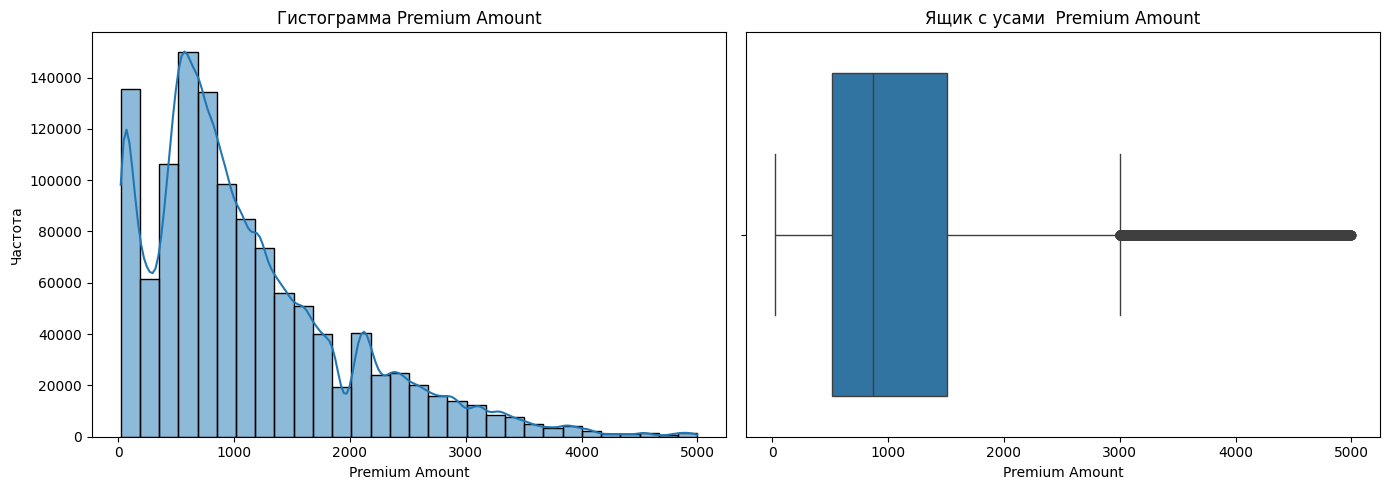

In [20]:
plot_histogram_box(train_data_encoded)

In [21]:
# Находим выбросы в Premium Amount с помощью IQR
Q1 = train_data_encoded["Premium Amount"].quantile(0.30)
Q3 = train_data_encoded["Premium Amount"].quantile(0.70)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаляем выбросы
train_data_new = train_data_encoded[(train_data_encoded["Premium Amount"] >= lower_bound) & 
                                        (train_data_encoded["Premium Amount"] <= upper_bound)]

# Проверяем размер после удаления выбросов
print(f"Количество строк после удаления выбросов: {train_data_new.shape[0]}")

Количество строк после удаления выбросов: 1097680


In [22]:
train_data_new

,id,Age,Annual Income,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,...,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Property Type,Premium Amount,Gender_Male,Marital Status_Married,Marital Status_Single,Smoking Status_Yes
1,1,39.0,31678.0,3.0,2,2,15.569731,0,1,1.0,...,2.0,4,1,1,2,1483.0,False,False,False,True
2,2,23.0,25602.0,3.0,1,1,47.177549,1,2,1.0,...,3.0,4,2,3,2,567.0,True,False,False,True
3,3,21.0,141855.0,2.0,0,2,10.938144,0,0,1.0,...,1.0,5,0,0,0,765.0,True,True,False,True
4,4,21.0,39651.0,1.0,0,1,20.376094,0,2,0.0,...,4.0,2,0,3,2,2022.0,True,False,True,True
6,6,41.0,40336.0,0.0,3,2,24.578648,0,0,2.0,...,6.0,1,0,3,2,439.0,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199994,1199994,34.0,23456.0,4.0,2,1,14.783439,0,0,1.0,...,9.0,4,2,1,0,1584.0,True,False,True,False
1199995,1199995,36.0,27316.0,0.0,2,0,13.772907,2,2,1.0,...,3.0,4,0,0,0,1303.0,False,True,False,False
1199996,1199996,54.0,35786.0,0.0,2,1,11.483482,0,1,1.0,...,4.0,3,0,3,0,821.0,True,False,False,False
1199997,1199997,19.0,51884.0,0.0,2,2,14.724469,1,0,0.0,...,6.0,2,2,1,1,371.0,True,False,False,False


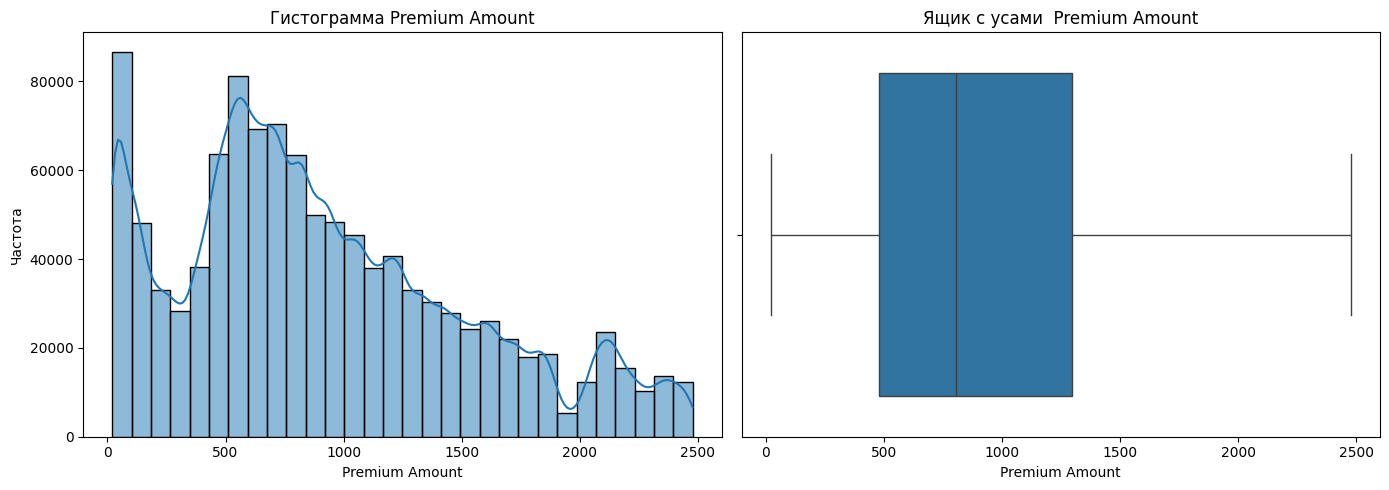

In [23]:
plot_histogram_box(train_data_new)

In [24]:
train_data_new.shape

(1097680, 22)

In [32]:

# Проверим выбросы в других числовых столбцах с использованием IQR
for col in ['Previous Claims', 'Annual Income']:
    Q1 = train_data_new[col].quantile(0.25)
    Q3 = train_data_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Удаляем выбросы
    train_data_new_2 = train_data_new[(train_data_new[col] >= lower_bound) & 
                                             (train_data_new[col] <= upper_bound)]
    
    print(f"Обработаны выбросы в столбце {col}.")
    

Обработаны выбросы в столбце Previous Claims.
Обработаны выбросы в столбце Annual Income.


In [35]:
num_col_del = ['id']
cat_col_del = ['']

plot_analize_data(train_data_new['Previous Claims'], num_col_del, cat_col_del)

AttributeError: 'Series' object has no attribute 'select_dtypes'

In [29]:
train_data_normalized = normalize_data(train_data_new.copy(), method="minmax")


print(train_data_normalized.head().to_string(index=False))

          id      Age  Annual Income  Number of Dependents  Education Level  Occupation  Health Score  Location  Policy Type  Previous Claims  Vehicle Age  Credit Score  Insurance Duration  Policy Start Date  Customer Feedback  Exercise Frequency  Property Type  Premium Amount  Gender_Male  Marital Status_Married  Marital Status_Single  Smoking Status_Yes
0.000000e+00 0.456522       0.211186                  0.75         0.666667         1.0      0.240429       0.0          0.5         0.111111     0.631579      0.717668               0.125                0.8                0.5            0.333333            1.0        0.595199        False                   False                  False                True
8.333354e-07 0.108696       0.170678                  0.75         0.333333         0.5      0.800963       0.5          1.0         0.111111     0.736842      0.533560               0.250                0.8                1.0            1.000000            1.0        0.222539       

In [30]:
train_data_normalized.shape

(1097680, 22)

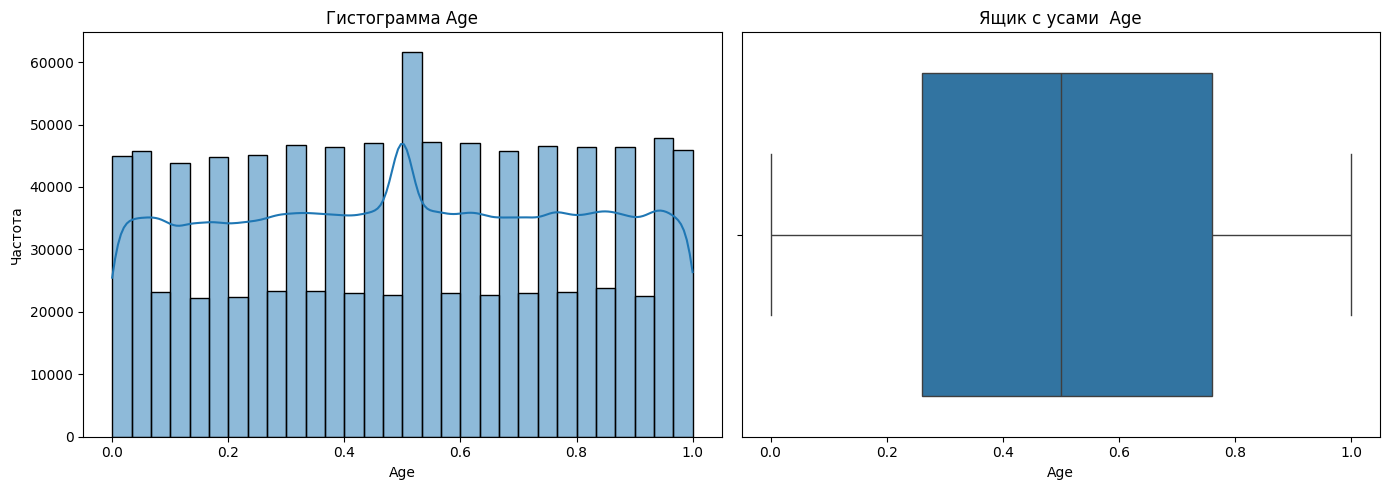

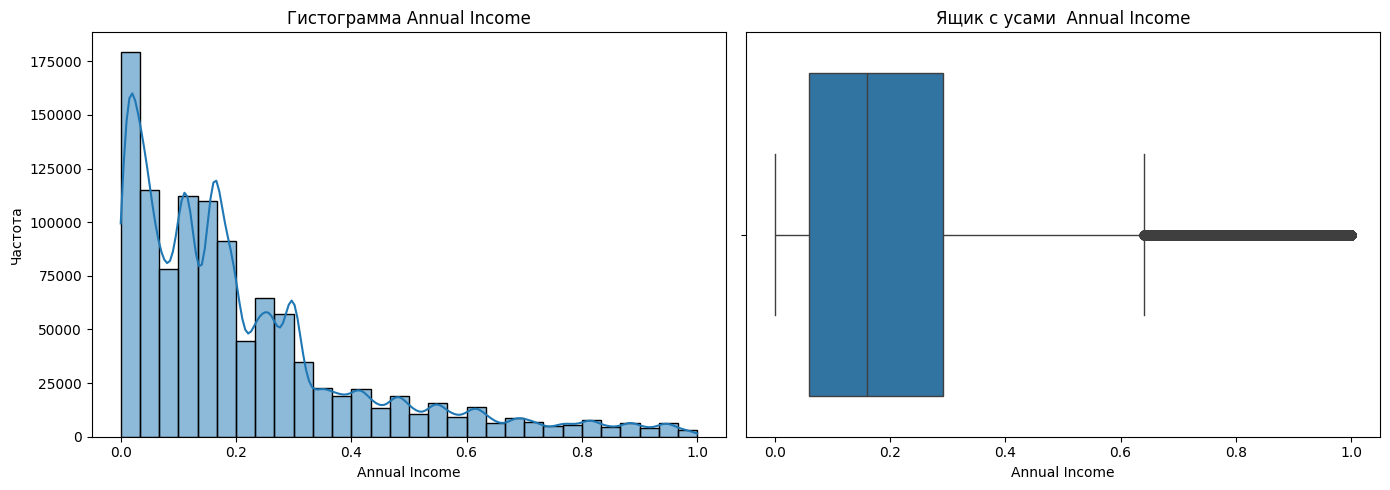

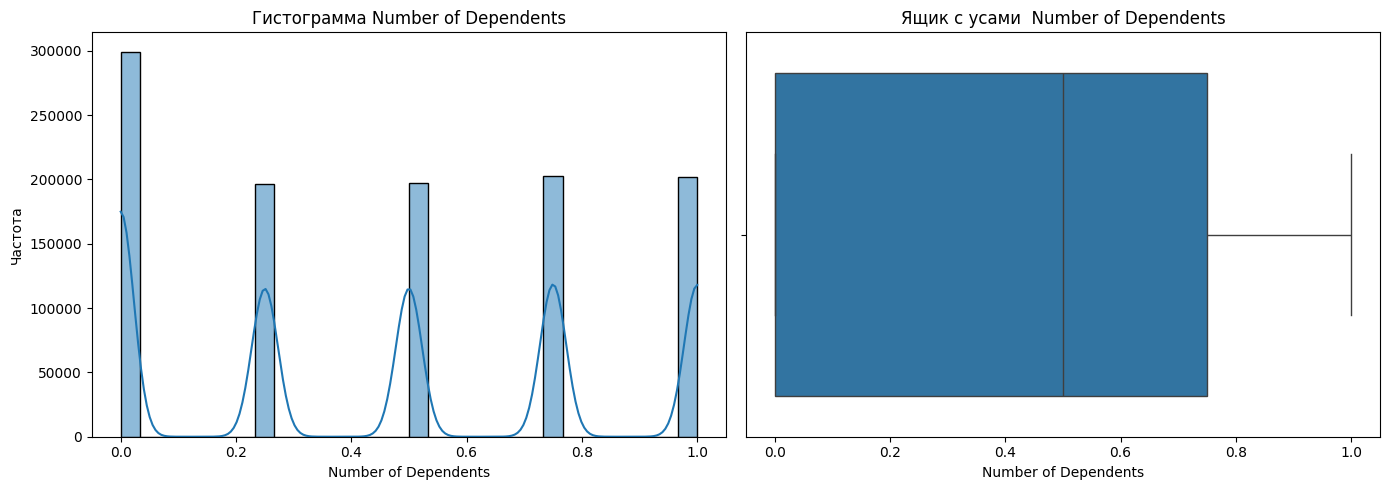

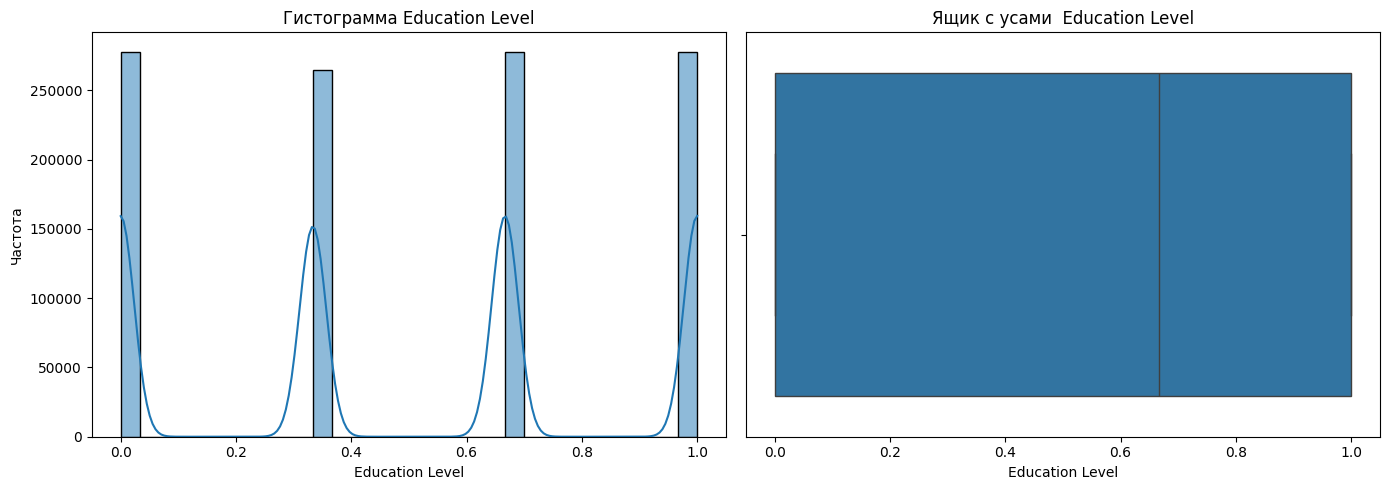

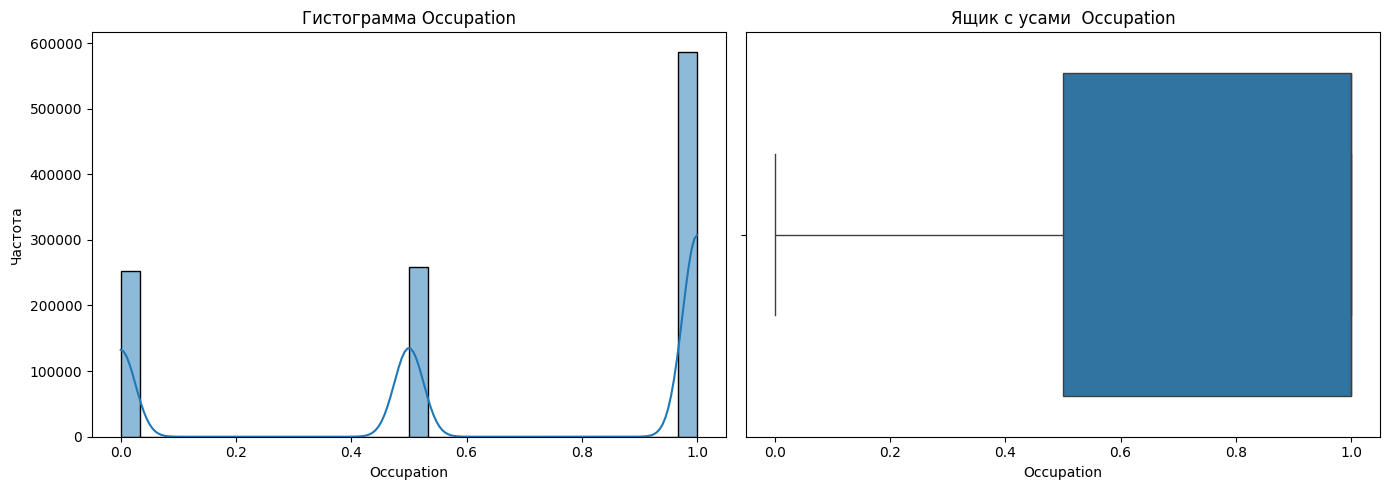

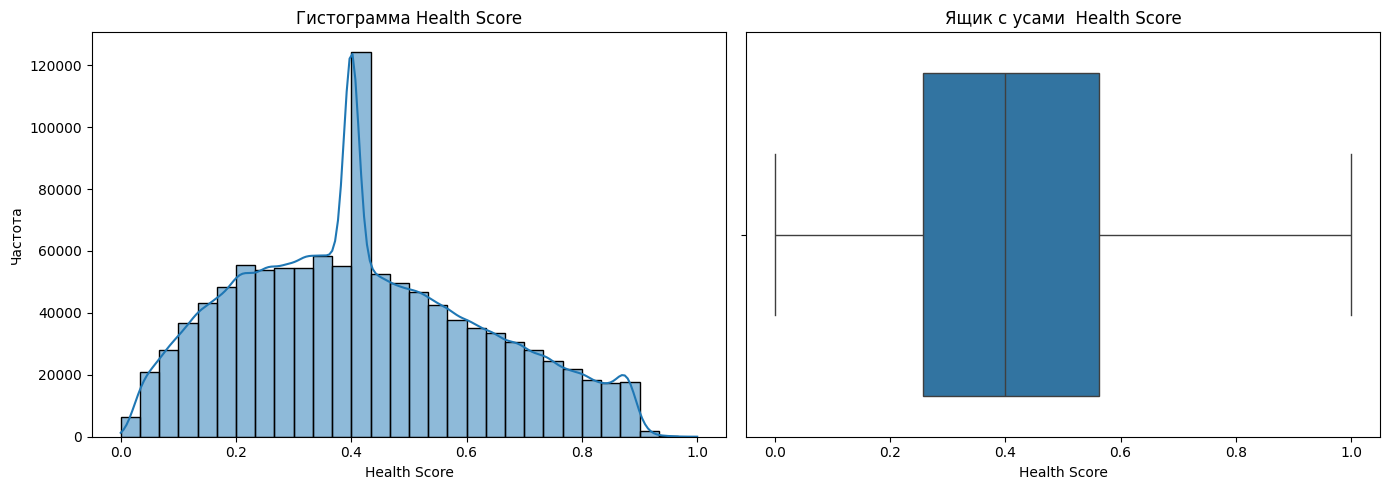

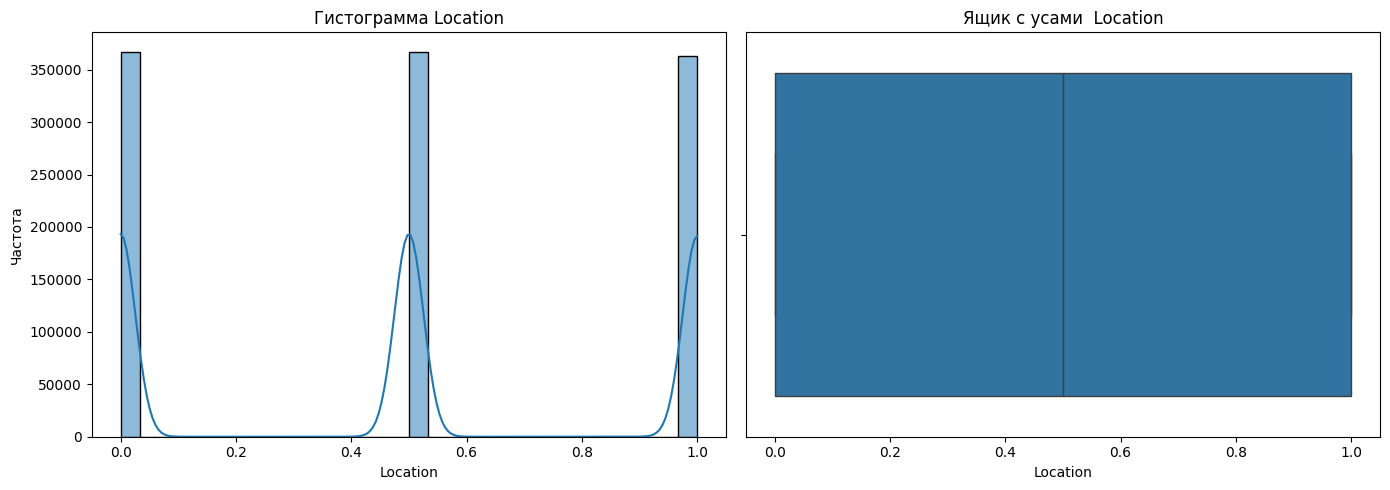

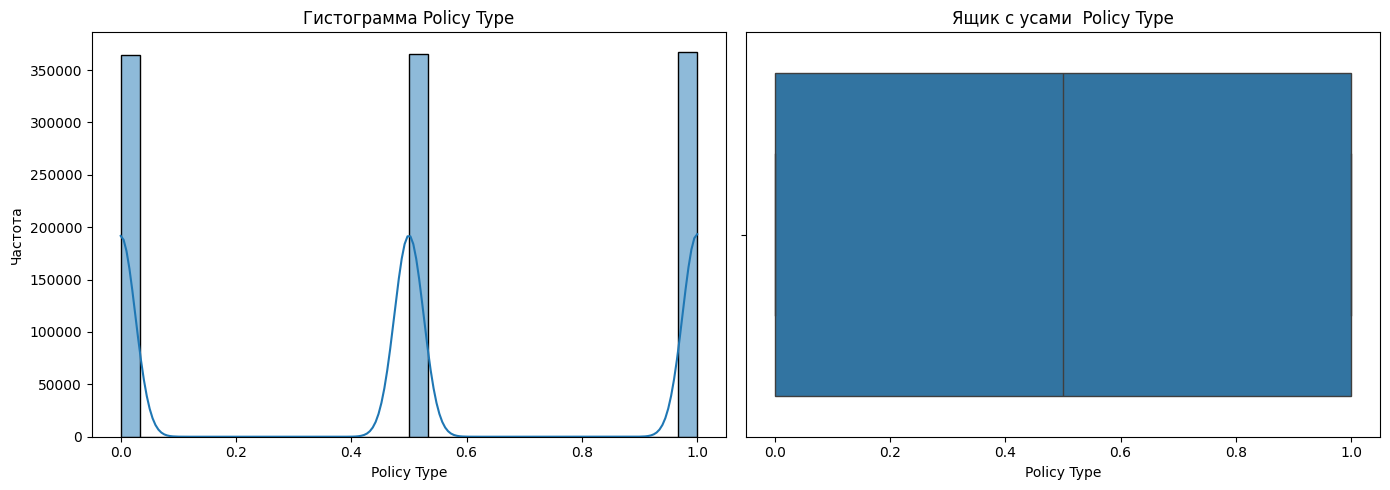

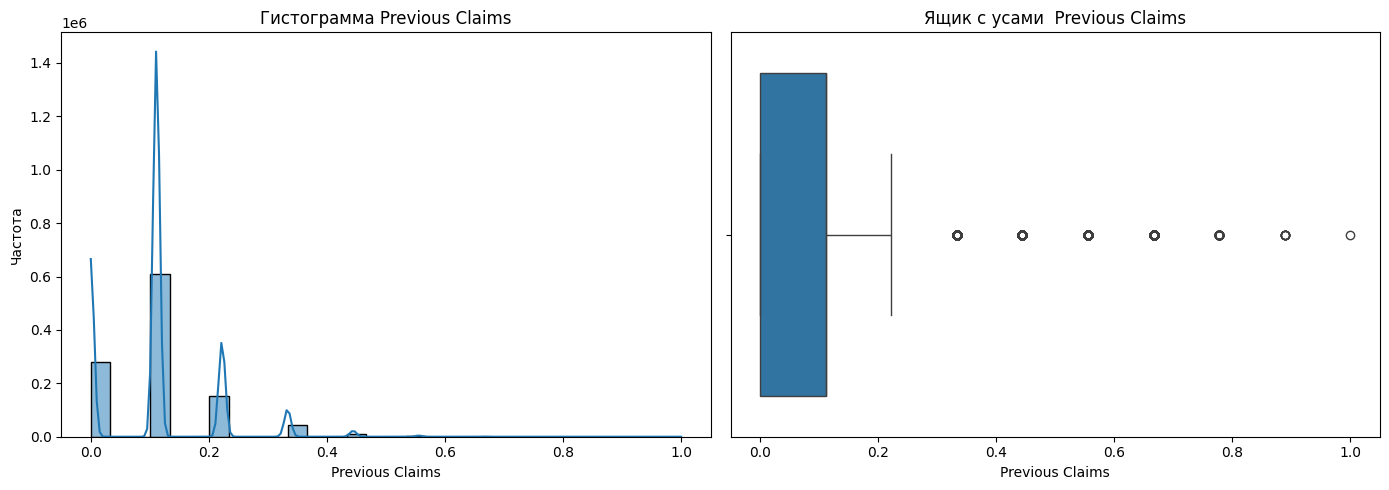

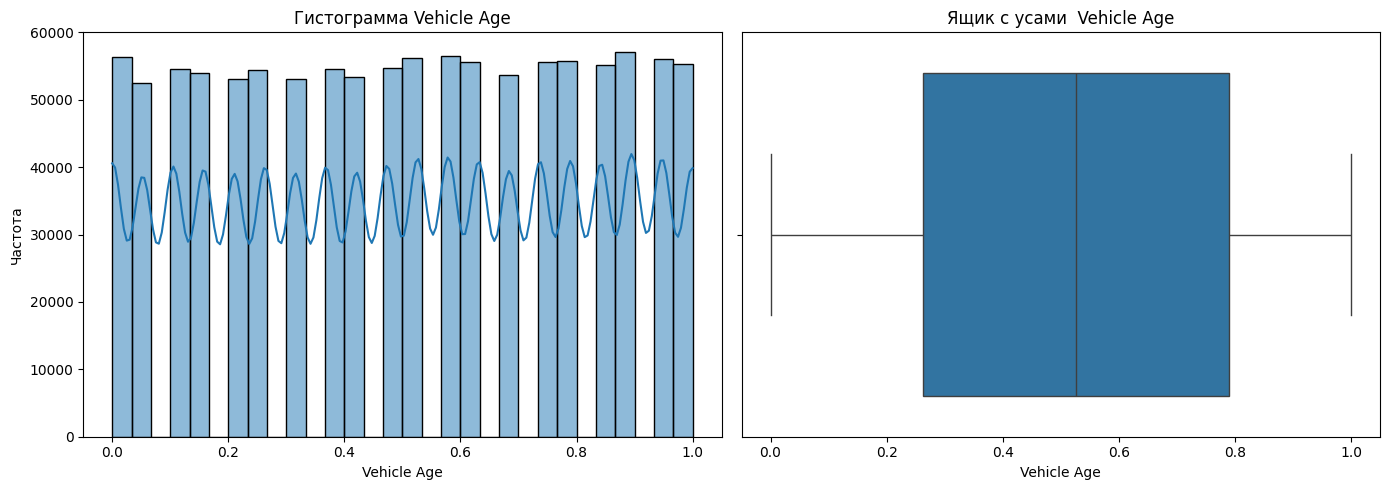

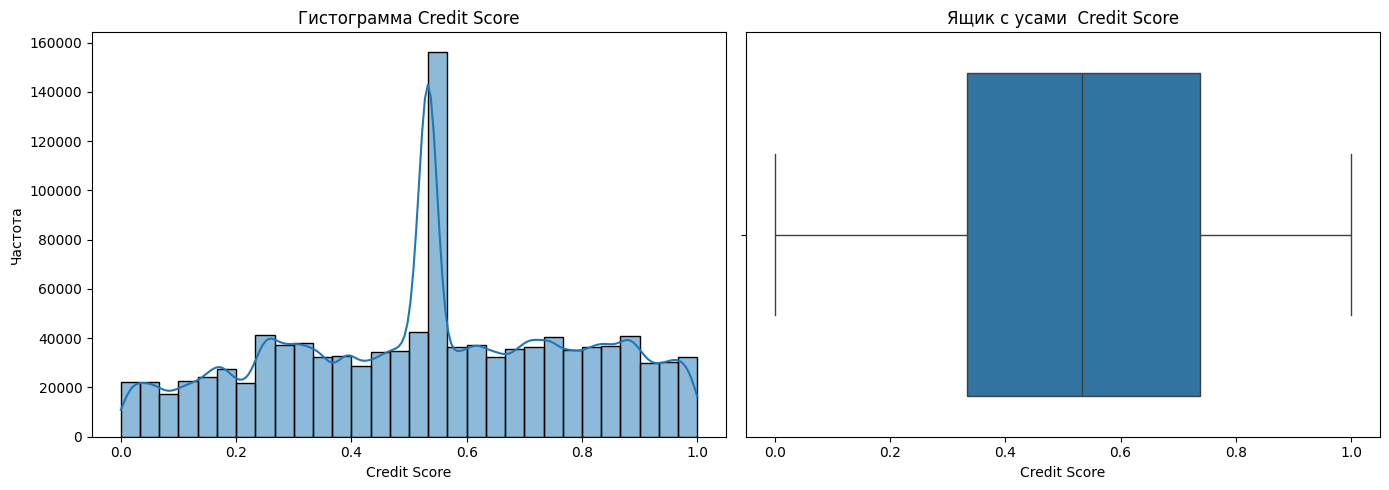

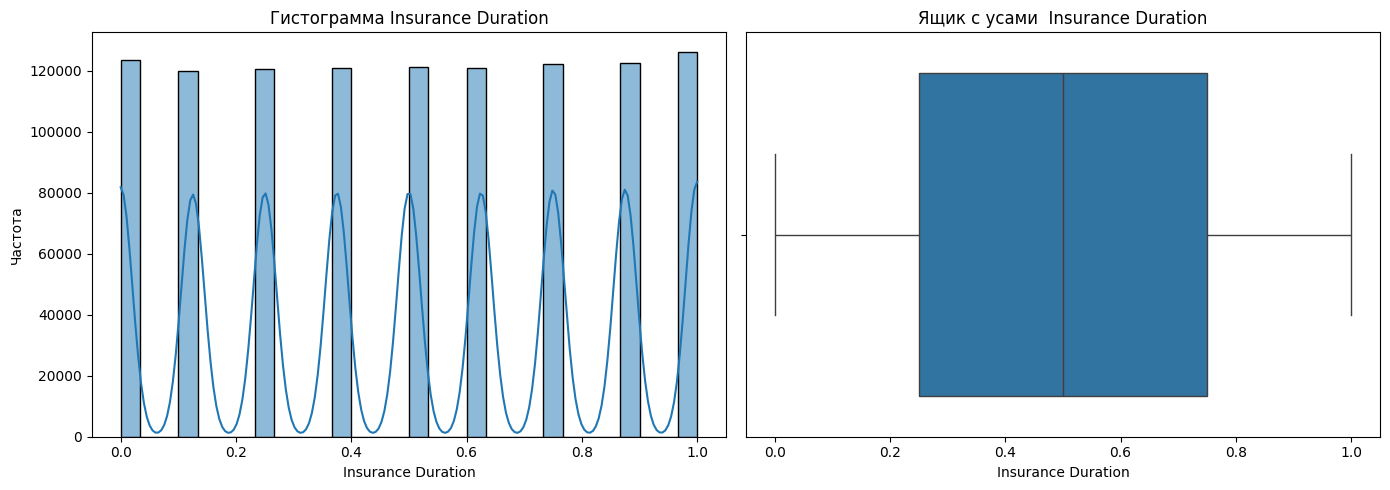

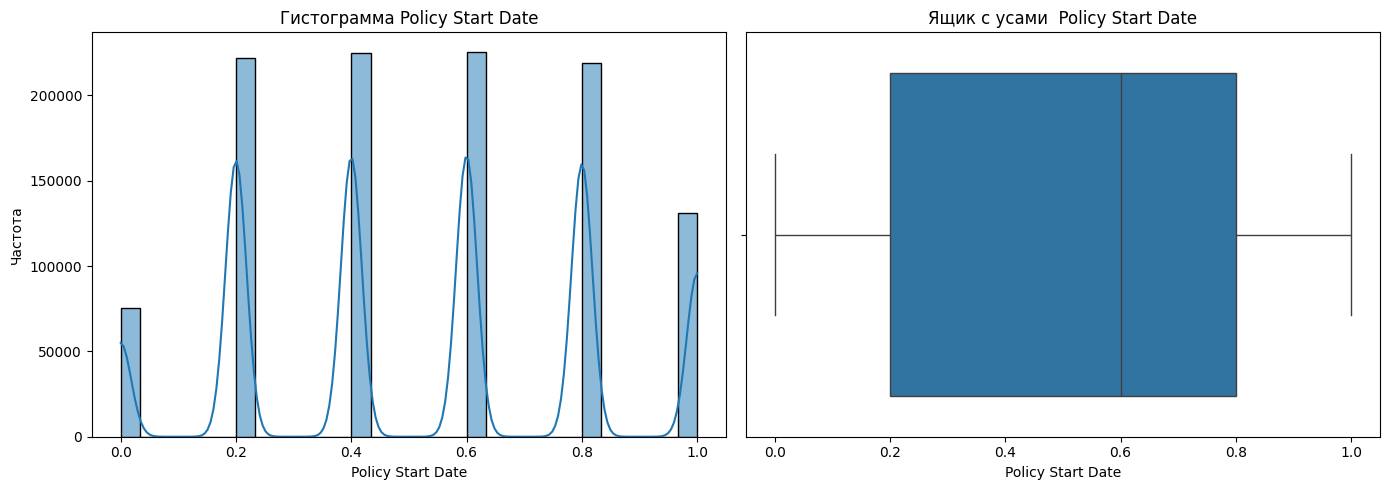

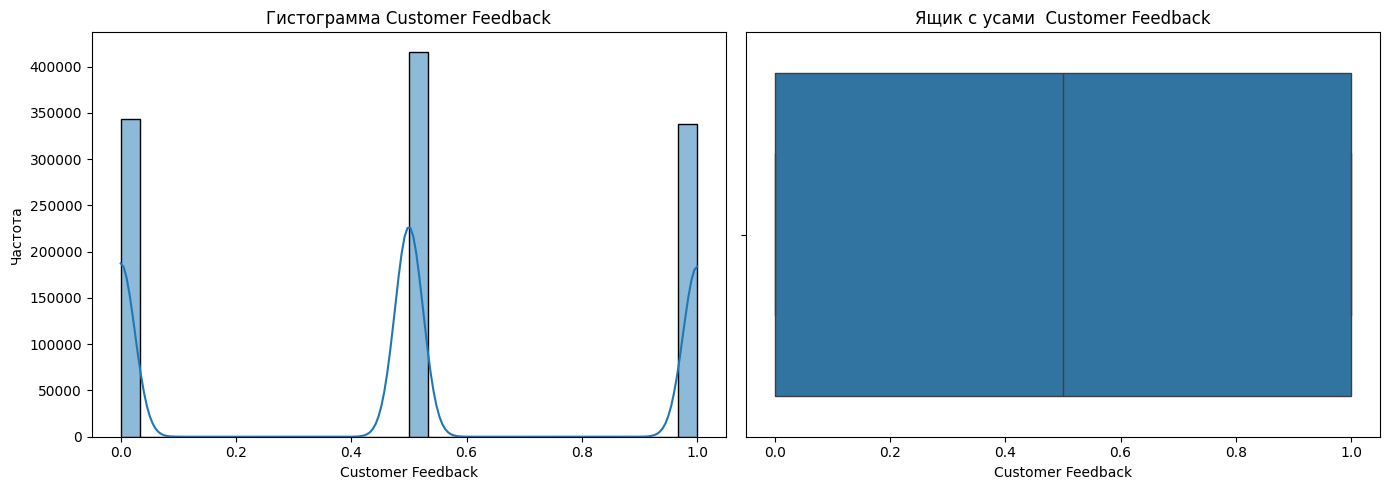

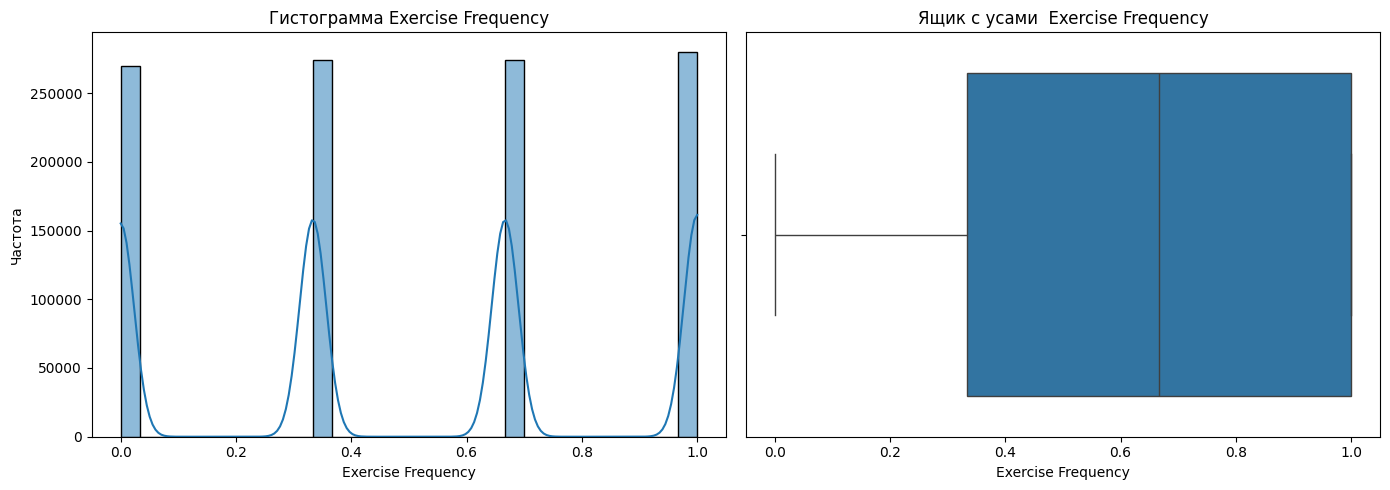

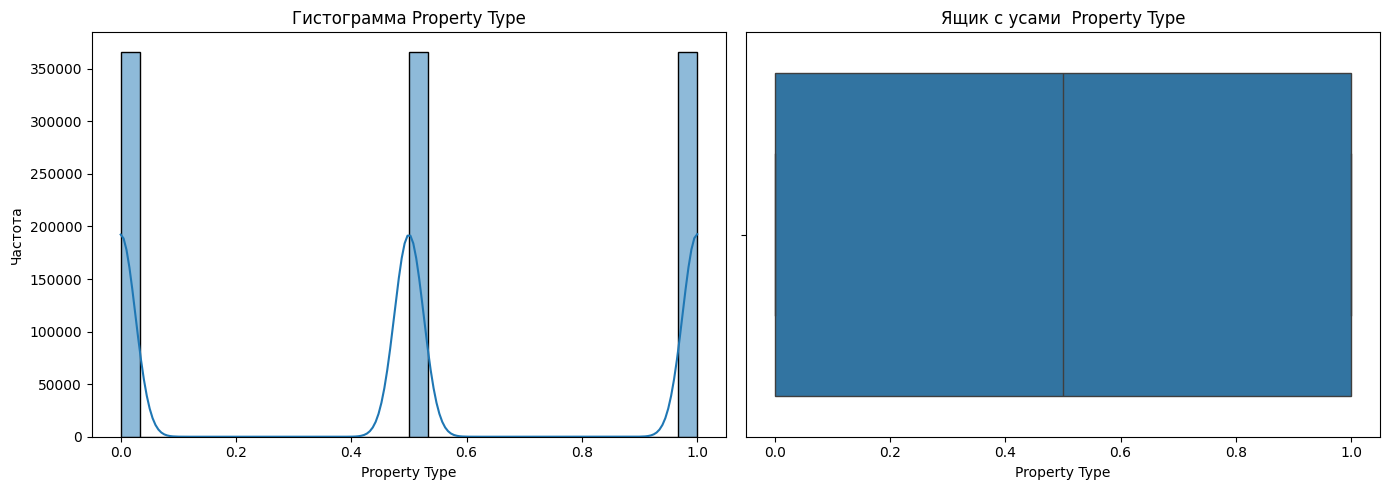

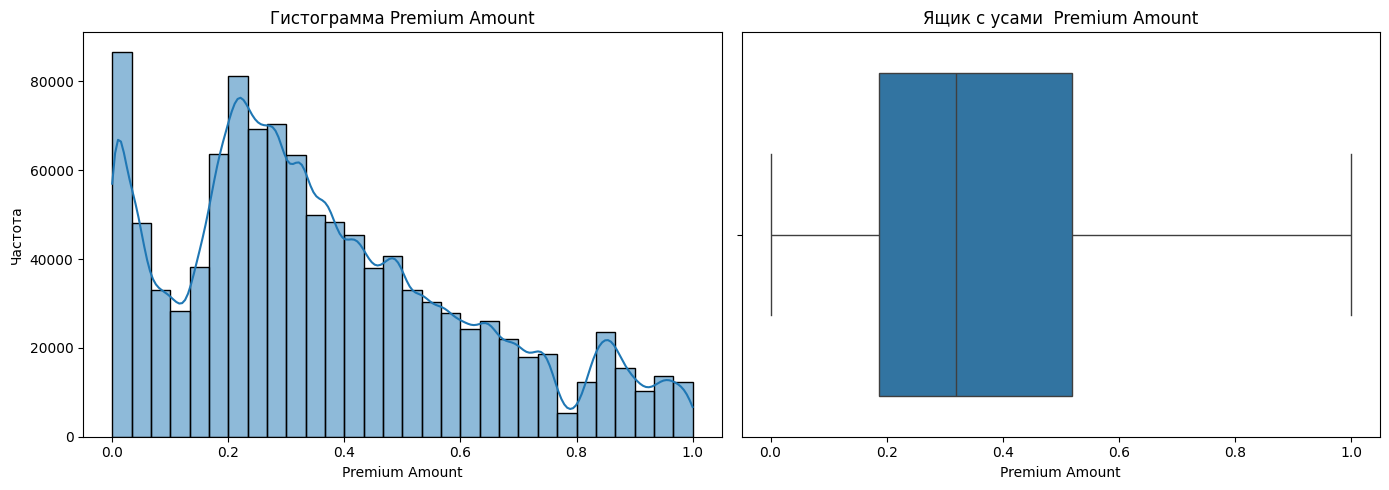

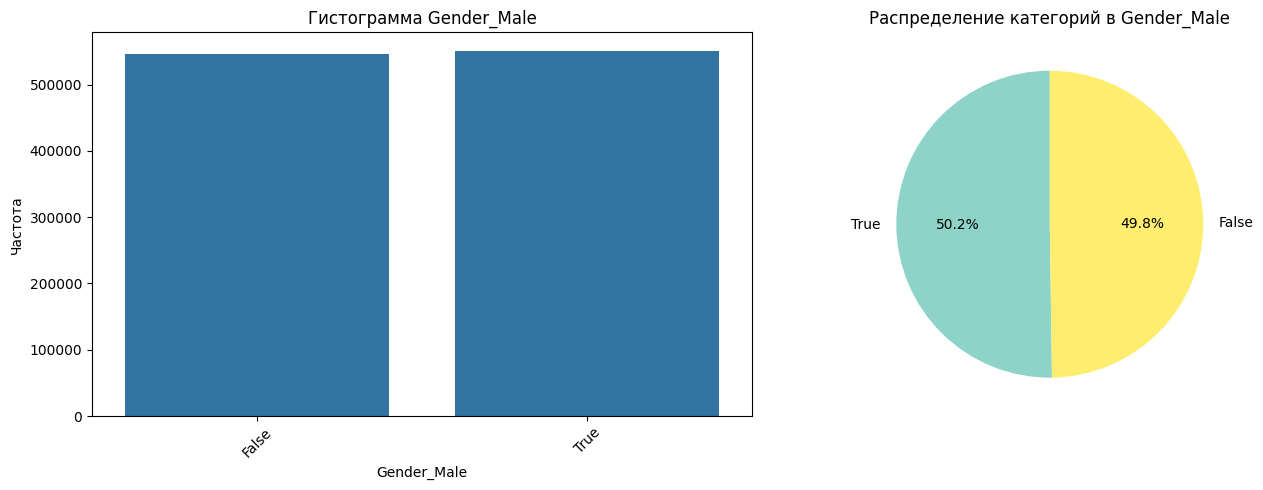

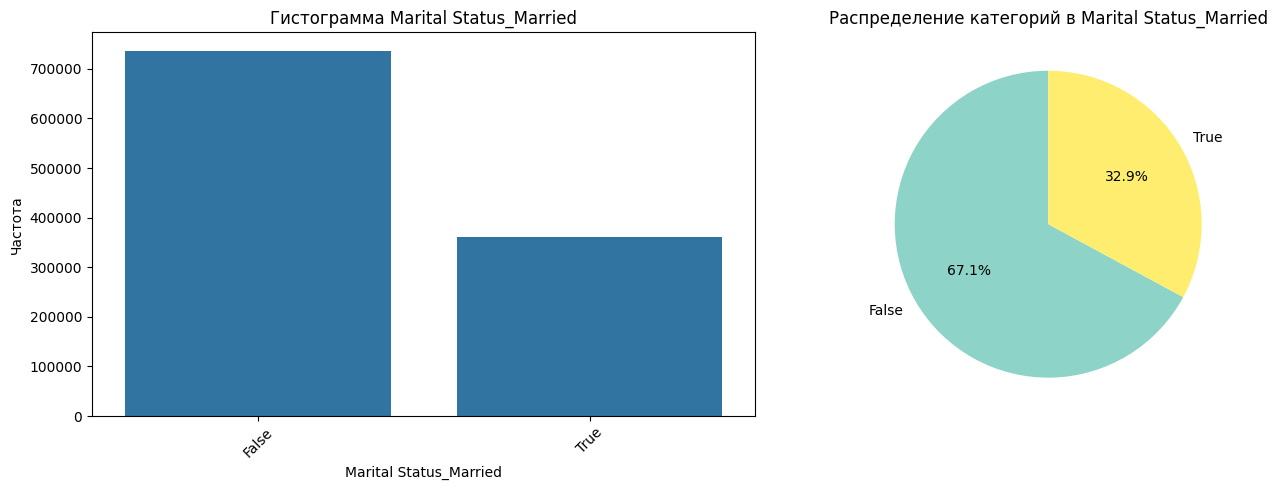

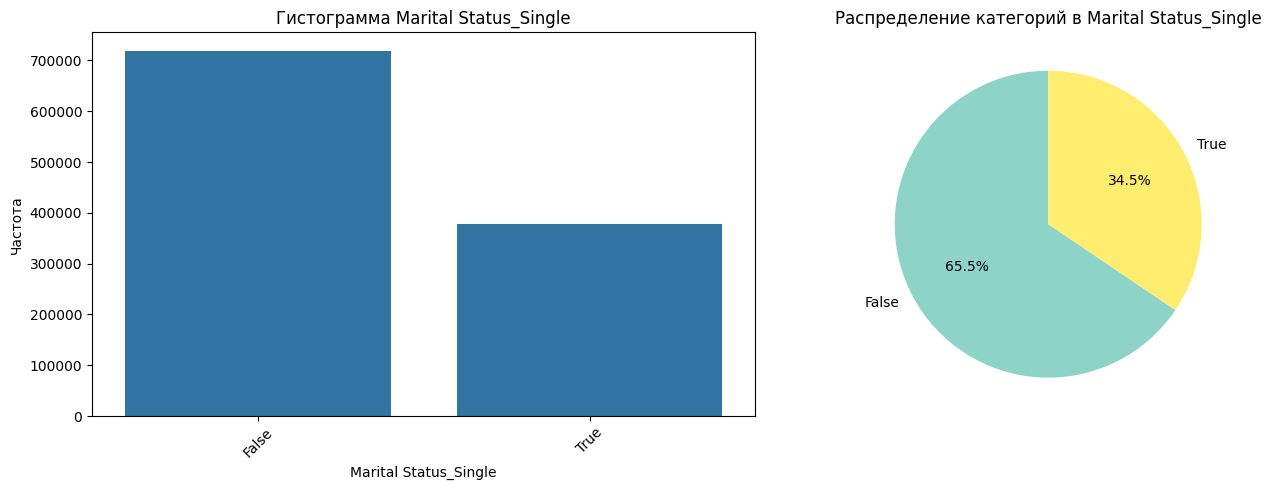

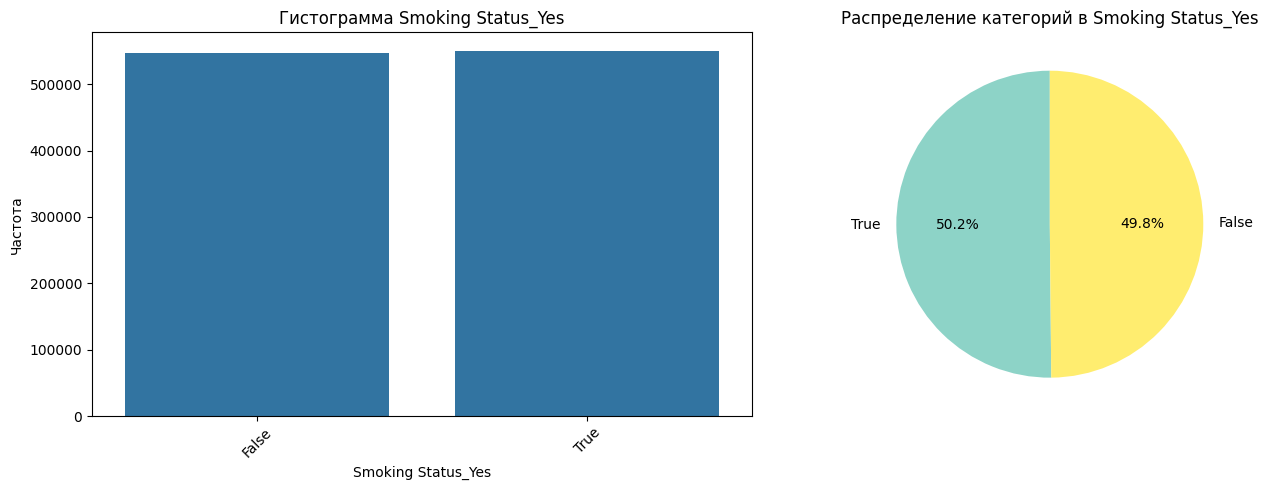

In [31]:
plot_analize_data(train_data_normalized, num_col_del, cat_col_del)